# Quantitative Analysis of Spike Trains

This notebook aims to quantify the spikes emitted from different populations of a neural network.

This may be done using one of 3 definitions of Mean firing rate:
    1. Temporal Averaging
    2. Average over trials
    3. Population average

We may also quantify the spike trains using the Coefficient of Variation in the Interspike Interval Distributions

### Importing the libraries

In [2]:
import spynnaker8 as p
import pyNN.spiNNaker as sim
import time
import matplotlib.pyplot as plt
import numpy as np
import statistics as st
from numpy import *
%matplotlib inline

## Model

In [3]:
model = p.Izhikevich
a_tonic = 0.02
b_tonic = 0.2
c_tonic = -65.0
d_tonic = 6.0
v_init_tonic = -65.0
u_init_tonic = b_tonic * v_init_tonic
current_Pulse = 0
tau_ex = 1.7
tau_inh = 2.5
cell_params = {'a': a_tonic, 
               'b': b_tonic, 
               'c': c_tonic, 
               'd': d_tonic, 
               'tau_syn_E': tau_ex, 
               'tau_syn_I': tau_inh, 
               'i_offset': current_Pulse}
initial_values = {'v': v_init_tonic, 'u': u_init_tonic}

### Setting up the spiNNaker simulator

In [4]:
start_time = time.time()
sim.setup(timestep = 0.1)
TotalDuration = 1000.0
TotalDuration2 = 1000.0
time_resol = 0.1
TimeInt = 1.0 / time_resol
TotalDataPoints = int(TotalDuration * TimeInt)
rate_Poisson_Inp_base = 25
print(TotalDuration)

2021-07-14 15:00:59 INFO: Read cfg files: /home/bbpnrsoa/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg, /home/bbpnrsoa/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg, /home/bbpnrsoa/.spynnaker.cfg
2021-07-14 15:00:59 INFO: Will search these locations for binaries: /home/bbpnrsoa/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/common_model_binaries : /home/bbpnrsoa/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/model_binaries
2021-07-14 15:00:59 WARNING: /home/bbpnrsoa/sPyNNakerGit/reports has 11 old reports that have not been closed
2021-07-14 15:00:59 WARNING: A timestep was entered that has forced sPyNNaker to automatically slow the simulation down from real time by a factor of 10. To remove this automatic behaviour, please enter a timescaleFactor value in your .spynnaker.cfg
2021-07-14 15:00:59 INFO: Setting time scale factor to 10.
2021-07-14 15:00:59 INFO: Setting machine time step to 100 micro-seconds.


['/home/bbpnrsoa/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']
1000.0


### Defining the number of cells in each population

In [5]:
# Number of Cells in each population
NumCells_exc = 80
NumCells_inh = 20
NumCells_extSource = 40

### Defining the connection parameters

In [6]:
# Synaptic Connection params
conn_delay = 1.0
conn_weights = 5.0
conn_prob = 0.232

### Parameters for Excitatory neurons

In [7]:
# Excitatory cell params
exc_a_tonic = 0.02
exc_b_tonic = 0.2
exc_c_tonic = -65.0
exc_d_tonic = 6.0
exc_v_init_tonic = -65.0
exc_u_init_tonic = exc_b_tonic * exc_v_init_tonic

### Parameters for Inhibitory neurons

In [8]:
# Inhibitory cell params
inh_a_tonic = 0.1
inh_b_tonic = 0.2
inh_c_tonic = -65.0
inh_d_tonic = 6.0
inh_v_init_tonic = -70.0
inh_u_init = inh_b_tonic * inh_v_init_tonic

### Time constants for Excitatory and Inhibitory neurons

In [9]:
# Time constants
tau_exc = 1.7
tau_inh = 2.5

In [10]:
# DC bias current
current_Pulse = 3.0

### Defining Cell Parameters

In [11]:
# Setting up the Cell Parameters
exc_cell_params = {
'a': exc_a_tonic, 'b': exc_b_tonic, 
'c': exc_c_tonic, 'd': exc_d_tonic,
#'v_init': exc_v_init_tonic, 'u_init': exc_u_init_tonic,
'tau_syn_E': tau_exc, 'tau_syn_I': tau_inh,
'i_offset': current_Pulse
               }

inh_cell_params = {
    'a' : inh_a_tonic, 'b': inh_b_tonic,
    
    'c': inh_c_tonic, 'd': inh_d_tonic,
    #'v_init' : inh_v_init_tonic,'u_init' : inh_u_init,
    'tau_syn_E' : tau_exc, 'tau_syn_I':tau_inh,
    'i_offset' : current_Pulse
               }

### Defining the neuron Populations

In [12]:
# Defining the populations
external_spike_source_pop = p.Population(NumCells_extSource,p.SpikeSourcePoisson,{'rate': rate_Poisson_Inp_base,'duration': 1000,'start': 100},label='spike_source_poisson')
exc_pop = p.Population(NumCells_exc, p.Izhikevich(**exc_cell_params), label='exc_pop')
inh_pop = p.Population(NumCells_inh, p.Izhikevich(**inh_cell_params), label='inh_pop')

### Defining the Projections between populations

In [13]:
# Defining the Projections between the various populations
#external to excitatory
Proj00 = p.Projection(external_spike_source_pop, exc_pop, p.FixedProbabilityConnector(p_connect=0.5),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#external to inhibitory
Proj01 = p.Projection(external_spike_source_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

# #excitatory to inhibitory
# Proj02 = p.Projection(exc_pop, inh_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

# #inhibitory to excitatory
# Proj03 = p.Projection(inh_pop, exc_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='inhibitory')

# #inhibitory to inhibitory
# Proj04 = p.Projection(inh_pop, inh_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='inhibitory')

# #excitatory to excitatory
# Proj05 = p.Projection(exc_pop, exc_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

### STDP MODEL

In [14]:
stdp_model = sim.STDPMechanism(timing_dependence = p.SpikePairRule(tau_plus=20.0, 
                                                                     tau_minus=20.0, 
                                                                     A_plus=0.045, 
                                                                     A_minus=0.045),
                               weight_dependence = p.AdditiveWeightDependence(w_min=0, 
                                                                                w_max=10)
                              )


# plastic_projection = sim.Projection(pre_pop, post_pop, sim.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)

In [15]:
#excitatory to inhibitory
Proj02 = p.Projection(exc_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)

#inhibitory to excitatory
Proj03 = p.Projection(inh_pop, exc_pop, p.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)

#inhibitory to inhibitory
Proj04 = p.Projection(inh_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)

#excitatory to excitatory
Proj05 = p.Projection(exc_pop, exc_pop, sim.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)

### Running the simulator and Recording Spikes and menbrane potential

In [16]:
NumberOfRepititions = 1
external_spike_source_Reps = []
exc_spikes_Reps = []
inh_spikes_Reps = []
exc_voltage_Reps = []
inh_voltage_Reps = []

for i in range(NumberOfRepititions):
    # Defining the populations
    p.reset()
    external_spike_source_pop = p.Population(NumCells_extSource,p.SpikeSourcePoisson,{'rate': rate_Poisson_Inp_base,'duration': 1000,'start': 100},label='spike_source_poisson')
    exc_pop = p.Population(NumCells_exc, p.Izhikevich(**exc_cell_params), label='exc_pop')
    inh_pop = p.Population(NumCells_inh, p.Izhikevich(**inh_cell_params), label='inh_pop')
    
    # Defining the Projections between the various populations
    #external to excitatory
    Proj00 = p.Projection(external_spike_source_pop, exc_pop, p.FixedProbabilityConnector(p_connect=0.5), p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

    #external to inhibitory
    Proj01 = p.Projection(external_spike_source_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5), p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

    #excitatory to inhibitory
    Proj02 = p.Projection(exc_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)

    #inhibitory to excitatory
    Proj03 = p.Projection(inh_pop, exc_pop, p.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)

    #inhibitory to inhibitory
    Proj04 = p.Projection(inh_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)

    #excitatory to excitatory
    Proj05 = p.Projection(exc_pop, exc_pop, sim.FixedProbabilityConnector(p_connect=0.5), synapse_type=stdp_model)


    # Record spikes from Ext Source, Spikes AND menbrance voltage from the excitatory and inhibitory populations
    external_spike_source_pop.record("spikes")
    exc_pop.record(("spikes", "v"))
    inh_pop.record(("spikes", "v"))
    p.run(TotalDuration)

    # Retrieve data from simulation
    external_spike_source = external_spike_source_pop.spinnaker_get_data("spikes")
    exc_spikes = exc_pop.spinnaker_get_data("spikes")
    inh_spikes = inh_pop.spinnaker_get_data("spikes")
    exc_voltage = exc_pop.spinnaker_get_data("v")
    inh_voltage = inh_pop.spinnaker_get_data("v")
    
    print(f"Repitition number {i}:")
    print(len(exc_spikes))
    print(len(inh_spikes))
    print(len(external_spike_source))
    print(exc_spikes)
    
    external_spike_source_Reps.append(external_spike_source)
    exc_spikes_Reps.append(exc_spikes)
    inh_spikes_Reps.append(inh_spikes)
    exc_voltage_Reps.append(exc_voltage)
    inh_voltage_Reps.append(inh_voltage)

2021-07-14 15:01:52 INFO: Resetting
2021-07-14 15:01:52 WARNING: /home/bbpnrsoa/sPyNNakerGit/reports has 12 old reports that have not been closed
2021-07-14 15:01:52 INFO: Starting execution process
2021-07-14 15:01:52 INFO: Simulating for 10000 0.1ms timesteps using a hardware timestep of 1000us
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2021-07-14 15:01:52 INFO: Time 0:00:00.009780 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2021-07-14 15:01:52 INFO: Time 0:00:00.011989 taken by DelaySupportAdder
2021-07-14 15:01:55 INFO: Time 0:00:02.938656 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2021-07-14 15:02:03 INFO: Time 0:00:08.138071 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%         

Repitition number 0:
7224
2592
908
[[  0.   16.2]
 [  0.  105.6]
 [  0.  113.2]
 ...
 [ 79.  824.1]
 [ 79.  824.7]
 [ 79.  969.8]]


### Analyzing the spikes

In [17]:
for i in range(NumberOfRepititions):
    print(len(exc_spikes_Reps[i]))
    print(len(inh_spikes_Reps[i]))
    print(len(external_spike_source_Reps[i]))
    print('...................')

7224
2592
908
...................


There are #NumberOfRepitions experiment repititions, for each of these, we calculate 3 arrays:

#### Please note the difference between exc_spike_count_Reps and exc_spikes_Reps

#### exc_spike_count_Reps is the count for each neuron, the latter is the Array Generated by SpiNNaker on the ith Repitition

In [18]:
exc_spike_count_Reps = []
inh_spike_count_Reps = []
external_spike_count_Reps = []
TotalDuration = TotalDuration2/1000.0      # Total duration in seconds

### Mean Firing Rate - Temporal Averaging

In [19]:
for i in range(NumberOfRepititions):
    exc_spikes = exc_spikes_Reps[i]            # Retrieve the exc_spikes array for the ith repitition
    exc_neuron_spike_count = []                # Count of spikes emitted by each of the neurons in the population

    for i in range (NumCells_exc):             # Initialize list
        exc_neuron_spike_count.append(0)

    for i in range (len(exc_spikes)):   
        neuron = int(exc_spikes[i][0])
        exc_neuron_spike_count[neuron] += 1
        
    exc_spike_count_Reps.append(exc_neuron_spike_count)
    
    exc_neuron_mfr = []                        # Mean firing rate: Spikes/second for each of the neuron

    for i in range (NumCells_exc):
        exc_neuron_mfr.append(exc_neuron_spike_count[i]/TotalDuration)


for i in range (NumberOfRepititions):
    print(len(exc_spike_count_Reps[i]))
    print(exc_spike_count_Reps[i])
    print("..........................")

80
[186, 72, 131, 58, 79, 138, 75, 175, 95, 79, 92, 97, 79, 94, 90, 97, 106, 76, 72, 98, 88, 138, 69, 97, 76, 83, 95, 96, 68, 84, 89, 77, 144, 77, 123, 89, 85, 68, 80, 132, 82, 62, 77, 112, 81, 88, 71, 81, 98, 77, 87, 98, 95, 98, 79, 89, 79, 89, 86, 91, 91, 84, 69, 84, 84, 72, 134, 79, 70, 89, 81, 80, 85, 84, 97, 66, 84, 82, 71, 71]
..........................


In [20]:
for i in range (NumberOfRepititions):
    
    inh_spikes = inh_spikes_Reps[i]            # The inh_spikes generated at the ith repitition
    
    inh_neuron_spike_count = []                # Count of spikes emitted by each of the neurons in the population

    for i in range (NumCells_inh):             # Initialize list
        inh_neuron_spike_count.append(0)

    for i in range (len(inh_spikes)):   
        neuron = int(inh_spikes[i][0])
        inh_neuron_spike_count[neuron] += 1

    inh_spike_count_Reps.append(inh_neuron_spike_count)
    
    inh_neuron_mfr = []                        # Mean firing rate: Spikes/second for each of the neuron

    for i in range (NumCells_inh):
        inh_neuron_mfr.append(inh_neuron_spike_count[i]/TotalDuration)

#     print(inh_neuron_spike_count)
#     print(inh_neuron_mfr)
for i in range (NumberOfRepititions):
    print(len(inh_spike_count_Reps[i]))
    print(inh_spike_count_Reps[i])
    print("..........................")

20
[136, 135, 128, 120, 129, 142, 125, 135, 140, 124, 137, 137, 117, 129, 116, 125, 130, 119, 128, 140]
..........................


In [21]:
for i in range (NumberOfRepititions):
    
    # External spike Source generated at the ith repitition
    external_spike_source = external_spike_source_Reps[i]
    
    external_neuron_spike_count = []                # Count of spikes emitted by each of the neurons in the population

    for i in range (NumCells_extSource):             # Initialize list
        external_neuron_spike_count.append(0)

    for i in range (len(external_spike_source)):   
        neuron = int(external_spike_source[i][0])
        external_neuron_spike_count[neuron] += 1

    external_spike_count_Reps.append(external_neuron_spike_count)
    
    external_neuron_mfr = []                        # Mean firing rate: Spikes/second for each of the neuron

    for i in range (NumCells_extSource):
        external_neuron_mfr.append(external_neuron_spike_count[i]/TotalDuration)

#     print(external_neuron_spike_count)
#     print(external_neuron_mfr)

for i in range (NumberOfRepititions):
    print(len(external_spike_count_Reps[i]))
    print(external_spike_count_Reps[i])
    print("..........................")

40
[28, 26, 26, 24, 17, 17, 22, 26, 27, 17, 30, 18, 24, 25, 22, 22, 33, 22, 17, 23, 21, 11, 18, 27, 29, 24, 20, 25, 22, 21, 24, 16, 22, 29, 27, 25, 18, 17, 29, 17]
..........................


In [22]:
# Average across all Neurons
exc_mfr_mean = (np.mean(exc_neuron_mfr))
inh_mfr_mean = (np.mean(inh_neuron_mfr))
external_mfr_mean = (np.mean(external_neuron_mfr))

#### Plotting MFR (average for neurons across population

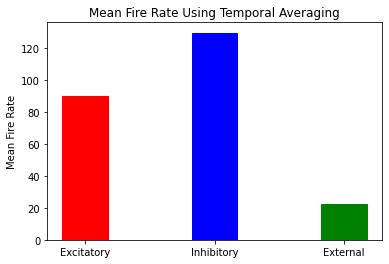

In [23]:
x_axis = ['Excitatory','Inhibitory','External']
y_axis = [exc_mfr_mean, inh_mfr_mean, external_mfr_mean]
barlist = plt.bar(x_axis,y_axis,width = 0.35)
barlist[0].set_color('red')
barlist[1].set_color('blue')
barlist[2].set_color('g')
plt.title('Mean Fire Rate Using Temporal Averaging')
plt.ylabel('Mean Fire Rate')
plt.savefig('mean_fire_rate_temporal.png')
plt.show()

### Printing spikes emitted by excitatory population

[[  0.   16.2]
 [  0.  105.6]
 [  0.  113.2]
 ...
 [ 79.  824.1]
 [ 79.  824.7]
 [ 79.  969.8]]
7224


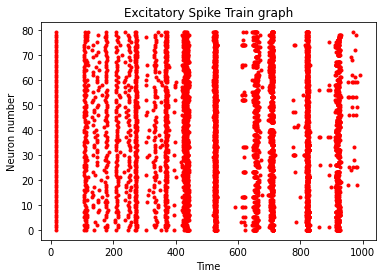

In [24]:
print(exc_spikes)
print(len(exc_spikes))
plt.figure(1)
plt.xlabel('Time')
plt.ylabel('Neuron number')
plt.title('Excitatory Spike Train graph')
plt.savefig('excitatory_raster.png')
plt.plot(exc_spikes[:, 1], exc_spikes[:, 0], '.',color = 'red')
#need to put x and y axis names 
#need to plot graphs for inhibitory and external source

### Printing spikes emitted by Inhibitory population

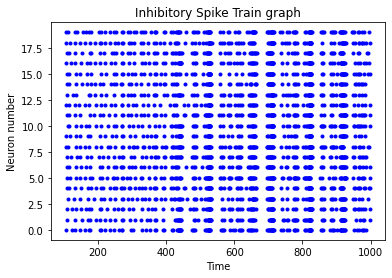

In [25]:
plt.figure(2)
plt.xlabel('Time')
plt.ylabel('Neuron number')
plt.title('Inhibitory Spike Train graph')
plt.savefig('inhibitory_raster.png')
plt.plot(inh_spikes[:, 1], inh_spikes[:, 0], '.', color = 'blue')

### Printing spikes emitted by external population

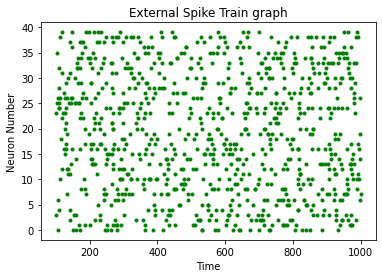

In [26]:
plt.figure(3)
plt.xlabel('Time')
plt.ylabel('Neuron Number')
plt.title('External Spike Train graph')
plt.savefig('external_raster.png')
plt.plot(external_spike_source[:, 1], external_spike_source[:, 0], '.',color = 'green')

### Excitatory Menbrane Potential

(800000, 3)


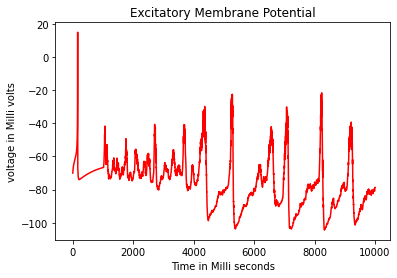

In [27]:
print(shape(exc_voltage))
exc_mem_voltage = np.reshape(exc_voltage[:, 2], [NumCells_exc, TotalDataPoints])
avgsignaltcr = np.mean(exc_mem_voltage, axis=0)
plt.figure(5)
plt.title('Excitatory Membrane Potential')
plt.xlabel('Time in Milli seconds')
plt.ylabel('voltage in Milli volts')
plt.savefig('excitatory_membrance_voltage.png')
plt.plot([x for x in range(TotalDataPoints)], avgsignaltcr,color = 'red')
plt.plot(exc_mem_voltage[:, 1], exc_mem_voltage[:, 2],)

### Inhibitory Menbrane Potential

[[-70.         -69.70477295 -69.42623901 ... -53.22860718 -51.76144409
  -50.25137329]
 [-70.         -69.70477295 -69.42623901 ... -52.28442383 -51.24954224
  -50.199646  ]
 [-70.         -69.70477295 -69.42623901 ... -62.62374878 -62.62451172
  -62.67263794]
 ...
 [-70.         -69.70477295 -69.42623901 ... -64.71517944 -64.71969604
  -64.75180054]
 [-70.         -69.70477295 -69.42623901 ... -56.89477539 -56.31115723
  -55.78042603]
 [-70.         -69.70477295 -69.42623901 ... -60.66357422 -60.59960938
  -60.5736084 ]]


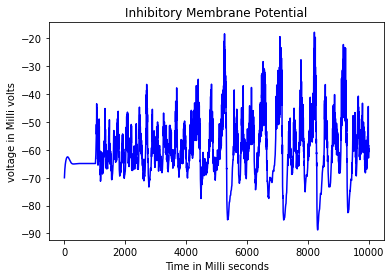

In [28]:
inh_mem_voltage = np.reshape(inh_voltage[:, 2], [NumCells_inh, TotalDataPoints])
print(inh_mem_voltage)
avgsignaltcr1 = np.mean(inh_mem_voltage, axis=0)
plt.figure(6)
plt.title('Inhibitory Membrane Potential')
plt.xlabel('Time in Milli seconds')
plt.ylabel('voltage in Milli volts')
plt.savefig('inhibitory_membrane_voltage.png')
plt.plot([x for x in range(TotalDataPoints)], avgsignaltcr1, color = 'blue')

## PSTH Calculation and graph

In [29]:
simulation_time_step = 0.1
bin_size = 1
per_bin_points = int(bin_size/simulation_time_step) # Number of points inside each bin, here bin is of duration 1ms.
Total_bins = TotalDataPoints//per_bin_points

# spike_count_list = []
# bin_list = []
# for i in range(Total_bins + 1):
#     spike_count_list.append(0)
# for i in range(len(exc_spikes)):
#     time_instance = int(exc_spikes[i][1]/bin_size)
#     spike_count_list[time_instance] += 1
# for i in range(Total_bins + 1):
#     bin_list.append(i)

In [ ]:
# plt.figure(1)
# plt.plot(bin_list,spike_count_list,color = 'red')
# plt.xlabel('Bins')
# plt.ylabel('Spikes')
# plt.title('Excitatory PSTH graph')
# plt.show()

In [ ]:
# inh_spike_count_list = []
# inh_bin_list = []
# for i in range(Total_bins+1):
#     inh_spike_count_list.append(0)
# for i in range(len(inh_spikes)):
#     inh_time_instance = int(inh_spikes[i][1] / bin_size)
#     inh_spike_count_list[inh_time_instance] += 1
# for i in range(Total_bins+1):
#     inh_bin_list.append(i)

In [ ]:
# plt.figure(2)
# plt.plot(inh_bin_list,inh_spike_count_list,color = 'blue')
# plt.xlabel('Bins')
# plt.ylabel('Spikes')
# plt.title('Inhibitory PSTH graph')
# plt.show()

In [ ]:
# external_spike_count_list = []
# external_bin_list = []
# for i in range(Total_bins + 1):
#     external_spike_count_list.append(0)
# for i in range(len(external_spike_source)):
#     external_time_instance = int(external_spike_source[i][1]/bin_size)
#     external_spike_count_list[external_time_instance] += 1
# for i in range(Total_bins + 1):
#     external_bin_list.append(i)

In [ ]:
# plt.figure(3)
# plt.plot(external_bin_list,external_spike_count_list,color = 'green')
# plt.xlabel('Bins')
# plt.ylabel('Spikes')
# plt.title('External PSTH graph')
# plt.show()

### Mean Firing Rate: Average over trials:

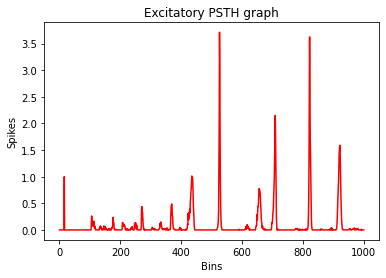

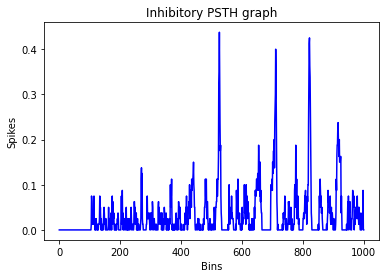

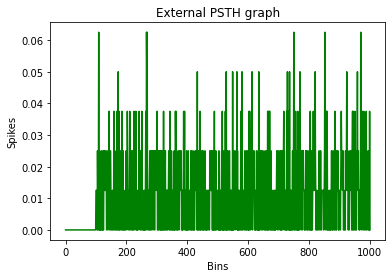

In [30]:
spike_count_list = []            # Initially stores counts of excitatory spikes in each bin ACROSS ALL REPS
inh_spike_count_list = []        # Initially stores counts of inhibitory spikes in each bin ACROSS ALL REPS
external_spike_count_list = []   # Initially stores counts of external spikes in each bin ACROSS ALL REPS

bin_list = []
for i in range(Total_bins + 1):
    spike_count_list.append(0)
for i in range(Total_bins + 1):
    inh_spike_count_list.append(0)
for i in range(Total_bins + 1):
    external_spike_count_list.append(0)
    
for i in range(Total_bins + 1):
    bin_list.append(i)
    
for j in range(NumberOfRepititions):
    exc_spikes = exc_spikes_Reps[j]
    for i in range(len(exc_spikes)):
        time_instance = int(exc_spikes[i][1]/bin_size)
        spike_count_list[time_instance] += 1
    
    inh_spikes = inh_spikes_Reps[j]
    for i in range(len(inh_spikes)):
        time_instance = int(inh_spikes[i][1]/bin_size)
        inh_spike_count_list[time_instance] += 1
    
    external_spike_source = external_spike_source_Reps[j]
    for i in range(len(external_spike_source)):
        time_instance = int(external_spike_source[i][1]/bin_size)
        external_spike_count_list[time_instance] += 1
    
for i in range(Total_bins + 1):  # Now, using the count stored, changing the value to the book's formula
    spike_count_list[i] /= NumberOfRepititions
    spike_count_list[i] /= NumCells_exc
    inh_spike_count_list[i] /= NumberOfRepititions
    inh_spike_count_list[i] /= NumCells_exc
    external_spike_count_list[i] /= NumberOfRepititions
    external_spike_count_list[i] /= NumCells_exc

plt.figure(1)
plt.plot(bin_list, spike_count_list, color = 'red')
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Excitatory PSTH graph')
plt.show()

plt.figure(2)
plt.plot(bin_list, inh_spike_count_list, color = 'blue')
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Inhibitory PSTH graph')
plt.show()

plt.figure(3)
plt.plot(bin_list, external_spike_count_list, color = 'green')
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('External PSTH graph')
plt.show()

# Mean firing rate (instantaneous, over several trials) in Fires/ms

### Ignore below

In [ ]:
# mean_fire_rate_avg_exc = []
# mean_fire_rate_avg_inh = []
# mean_fire_rate_avg_external = []

# for i in range(NumCells_exc):
#     sum_across_reps = 0
#     for j in range(NumberOfRepititions):
#         sum_across_reps += exc_spike_count_Reps[j][i]    # Add the spikes produced by neuron #i at the #jth Rep

#     mean_fire_rate_avg_exc.append(sum_across_reps / NumberOfRepititions)

# print(mean_fire_rate_avg_exc)
# # print(np.mean(mean_fire_rate_avg_exc))

# for i in range(NumCells_inh):
#     sum_across_reps = 0
#     for j in range(NumberOfRepititions):
#         sum_across_reps += inh_spike_count_Reps[j][i]    # Add the spikes produced by neuron #i at the #jth Rep

#     mean_fire_rate_avg_inh.append(sum_across_reps / NumberOfRepititions)

# print(mean_fire_rate_avg_inh)
# # print(np.mean(mean_fire_rate_avg_inh))

# for i in range(NumCells_extSource):
#     sum_across_reps = 0
#     for j in range(NumberOfRepititions):
#         sum_across_reps += external_spike_count_Reps[j][i] # Add the spikes produced by neuron #i at the #jth Rep
        
#     mean_fire_rate_avg_external.append(sum_across_reps / NumberOfRepititions)

# print(mean_fire_rate_avg_external)
# # print(np.mean(mean_fire_rate_avg_external))
        
# # mean_fire_rate_avg_exc1 = len(exc_spikes)/(NumCells_exc)
# # print(mean_fire_rate_avg_exc1)
# # mean_fire_rate_avg_inh1 = len(inh_spikes)/(NumCells_inh)
# # print(mean_fire_rate_avg_inh1)
# # mean_fire_rate_avg_external1 = len(external_spike_source)/(NumCells_extSource)
# # print(mean_fire_rate_avg_external1)

In [ ]:
# x_axis = ['Excitatory','Inhibitory','External']
# y_axis = [mean_fire_rate_avg_exc,mean_fire_rate_avg_inh,mean_fire_rate_avg_external]
# barlist = plt.bar(x_axis,y_axis,width = 0.35)
# barlist[0].set_color('red')
# barlist[1].set_color('blue')
# barlist[2].set_color('g')
# plt.title('Rate as Spike Density')
# plt.savefig('Average_of_trials.png')
# plt.ylabel('Mean Fire Rate')
# plt.show()

### Mean Firing Rate: Population Average:

In [ ]:
mean_fire_rate_pop_avg_exc = len(exc_spikes)/(NumCells_exc)
mean_fire_rate_pop_avg_inh = len(inh_spikes)/(NumCells_inh)
mean_fire_rate_pop_avg_external = len(external_spike_source)/(NumCells_extSource)
print(mean_fire_rate_pop_avg_exc)
print(mean_fire_rate_pop_avg_inh)
print(mean_fire_rate_pop_avg_external)

In [ ]:
x_axis = ['Excitatory','Inhibitory','External']
y_axis = [mean_fire_rate_pop_avg_exc,mean_fire_rate_pop_avg_inh,mean_fire_rate_pop_avg_external]
barlist = plt.bar(x_axis,y_axis,width = 0.35)
barlist[0].set_color('red')
barlist[1].set_color('blue')
barlist[2].set_color('g')
plt.title('Rate as a population average')
plt.savefig('Population_Average.png')
plt.ylabel('Mean Fire Rate')
plt.show()

## Calculating Coefficient of Variation in the ISI

### For Excitatory population

In [31]:
neuron_spike = []
for i in range(NumCells_exc):
    neuron_spike.append([])
    
for i in range(len(exc_spikes)):
    neuron = exc_spikes[i][0]
    neuron = int(neuron)
    neuron_spike[neuron].append(exc_spikes[i][1])

exc_cvs = []
for i in range(NumCells_exc):
    exc_cvs.append(0)

for i in range(NumCells_exc):
    distributions = []
    for j in range(1, len(neuron_spike[i])):
        distributions.append(neuron_spike[i][j] - neuron_spike[i][j-1])
    
    m = st.mean(distributions)
    std = st.stdev(distributions)
    cv = std / m
    exc_cvs[i] = cv

exc_cv_mean = st.mean(exc_cvs)
print(exc_cv_mean)    

2.4347175287217153


### For inhibitory population

In [32]:
neuron_spike = []
for i in range(NumCells_inh):
    neuron_spike.append([])
    
for i in range(len(inh_spikes)):
    neuron = inh_spikes[i][0]
    neuron = int(neuron)
    neuron_spike[neuron].append(inh_spikes[i][1])

inh_cvs = []
for i in range(NumCells_inh):
    inh_cvs.append(0)

for i in range(NumCells_inh):
    distributions = []
    for j in range(1, len(neuron_spike[i])):
        distributions.append(neuron_spike[i][j] - neuron_spike[i][j-1])
    
    m = st.mean(distributions)
    std = st.stdev(distributions)
    cv = std / m
    inh_cvs[i] = cv

inh_cv_mean = st.mean(inh_cvs)
print(inh_cv_mean)  

1.1726287481369018


### For External population

In [33]:
neuron_spike = []
for i in range(NumCells_extSource):
    neuron_spike.append([])
    
for i in range(len(external_spike_source)):
    neuron = external_spike_source[i][0]
    neuron = int(neuron)
    neuron_spike[neuron].append(external_spike_source[i][1])

external_cvs = []
for i in range(NumCells_extSource):
    external_cvs.append(0)

for i in range(NumCells_extSource):
    distributions = []
    for j in range(1, len(neuron_spike[i])):
        distributions.append(neuron_spike[i][j] - neuron_spike[i][j-1])
    
    m = st.mean(distributions)
    std = st.stdev(distributions)
    cv = std / m
    external_cvs[i] = cv


external_cv_mean = st.mean(external_cvs)
print(external_cv_mean)

0.952476019311496


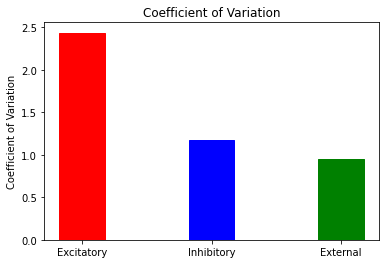

In [34]:
x_axis = ['Excitatory','Inhibitory','External']
y_axis = [exc_cv_mean, inh_cv_mean, external_cv_mean]
barlist = plt.bar(x_axis, y_axis, width = 0.35, align='center')
barlist[0].set_color('red')
barlist[1].set_color('blue')
barlist[2].set_color('g')
plt.title('Coefficient of Variation')
plt.ylabel('Coefficient of Variation')
plt.savefig('coefficientofvariation')
plt.show()